In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from IPython.display import Image

def display_images(image_path1, image_path2):
        # read images
        img_A = mpimg.imread(image_path1)
        img_B = mpimg.imread(image_path2)

        # pad top with white space
        larger = max(img_A.shape[0], img_B.shape[0])
        img_A = np.pad(img_A, ((larger - img_A.shape[0], 0), (0, 0), (0, 0)), mode='constant', constant_values=1)
        img_B = np.pad(img_B, ((larger - img_B.shape[0], 0), (0, 0), (0, 0)), mode='constant', constant_values=1)

        # stack
        img = np.concatenate((img_A, img_B), axis=1)
        # save tmp image
        tmp_path = 'tmp.png'
        plt.imsave(tmp_path, img)
        return Image(tmp_path, width=600)

### Basic Usage

Each model works by predicting a 2Mb contact map at any location. This 2Mb heatmap can then be further cropped to your region of interest. You need to provide the `--start` of the prediction window, and everything downstream 2Mb will be predicted. You can then specify the `--region` of interest to crop the 2Mb prediction, but be aware that this region must be contained within the prediction window.

You can run the `perturb.py` script without any perturbation arguments if you just want to make a prediction, but all perturbation examples will also save the original prediction so this is not usually necessary. 

You must pass the `--model` argument to specify the model checkpoint, the `--seq` argument to specify the location of the chromosome split FASTA files, and the `--bigwigs` argument to specify the location of the input bigwig tracks. These must be provided in the same order as the model was trained.

In [6]:
! python ../src/cshark/inference/perturb.py \
    --celltype hESC_WT_50pct \
    --outname baseline \
    --chr chr7 \
    --start 23000000 \
    --model ../checkpoints/deeploop_hESC_EP_CTCF_fix.ckpt \
    --seq ../cshark_data/data/hg19/dna_sequence \
    --region chr7:23200000-23700000 \
    --min-val-pred 0.5 \
    --bigwigs ctcf=../cshark_data/data/hg19/hESC_WT_50pct/genomic_features/ctcf.bw \
              h3k27ac=../cshark_data/data/hg19/hESC_WT_50pct/genomic_features/h3k27ac.bw \
              h3k4me3=../cshark_data/data/hg19/hESC_WT_50pct/genomic_features/h3k4me3.bw

Here we compare the experimental data to the prediction:

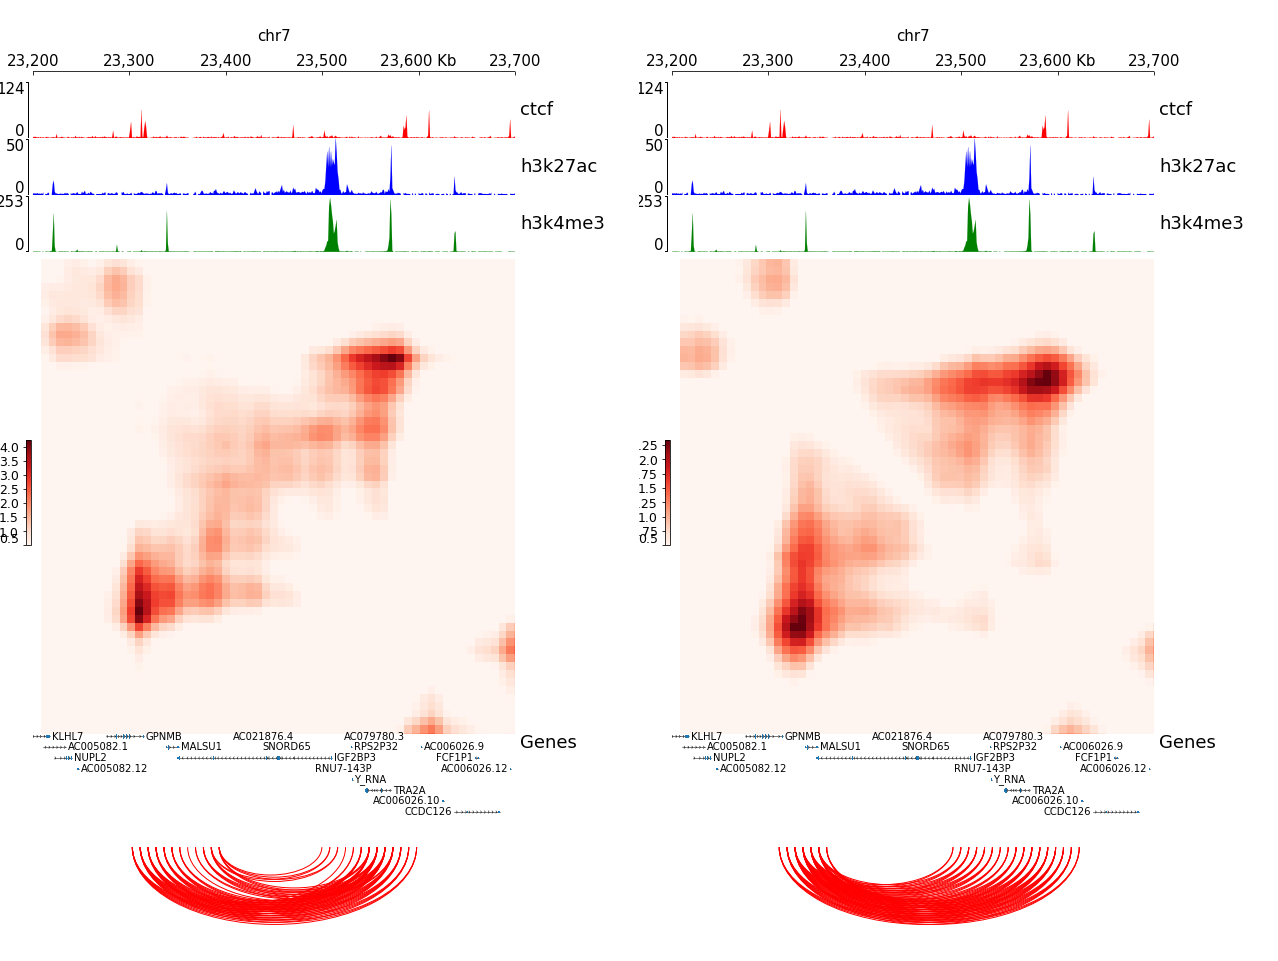

In [7]:
display_images('outputs/baseline_hESC_WT_50pct_chr7_23000000_ctcf_true_tracks.png', 
               'outputs/baseline_hESC_WT_50pct_chr7_23000000_ctcf_pred_tracks.png')

### CTCF Knockout

You can perform CTCF knockout by specifying the `--ko-start` and `--ko-width` arguments. This can accept a list of starts and width to knockout multiple sites or you can set `--ko-start` to the `--start` value and `--ko-width` to 2Mb to knockout the entire region.

There are several "knockout modes" we implement. We recommend using the default `--ko-mode knockout` which detects peaks and sets their value to the background.

In [8]:
! python ../src/cshark/inference/perturb.py \
    --celltype hESC_WT_50pct \
    --outname ctcf_ko_only \
    --chr chr7 \
    --start 23000000 \
    --model ../checkpoints/deeploop_hESC_EP_CTCF_fix.ckpt \
    --seq ../cshark_data/data/hg19/dna_sequence \
    --region chr7:23200000-23700000 \
    --ko-start 23580000 \
    --ko-width 10000 \
    --ko ctcf \
    --ko-mode knockout \
    --min-val-pred 0.5 \
    --bigwigs ctcf=../cshark_data/data/hg19/hESC_WT_50pct/genomic_features/ctcf.bw \
              h3k27ac=../cshark_data/data/hg19/hESC_WT_50pct/genomic_features/h3k27ac.bw \
              h3k4me3=../cshark_data/data/hg19/hESC_WT_50pct/genomic_features/h3k4me3.bw

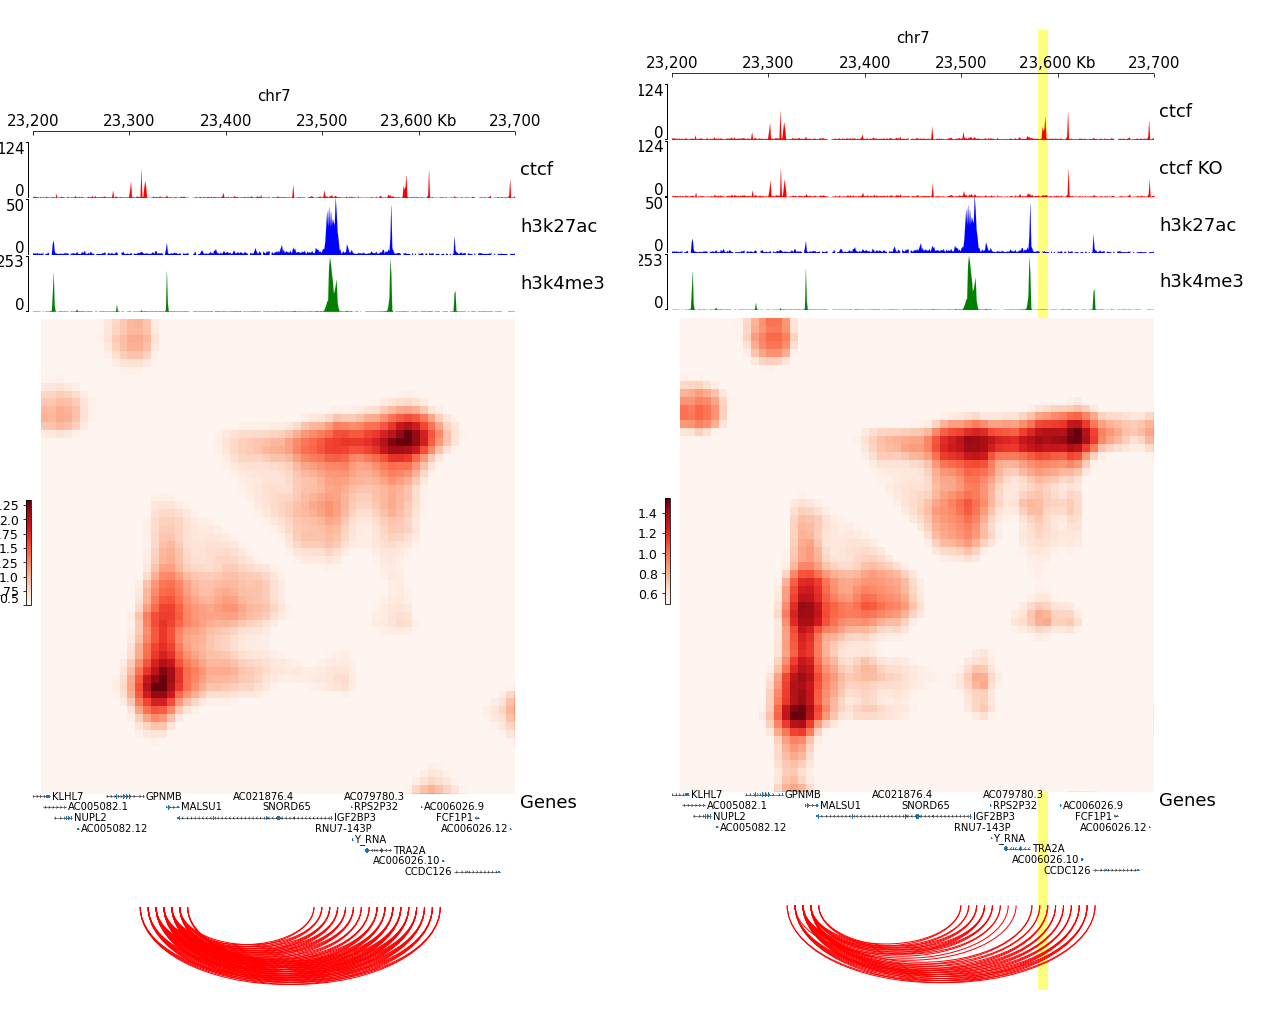

In [9]:
display_images('outputs/ctcf_ko_only_hESC_WT_50pct_chr7_23000000_ctcf_pred_tracks.png', 
               'outputs/ctcf_ko_only_hESC_WT_50pct_chr7_23000000_ctcf_ko_tracks.png')

You can also provide the `--plot-diff` flag with `--min-val-diff` and `--max-val-diff` to plot the difference between WT and KO predictions. This will also save the ground truth, WT, and KO predictions as before.


In [10]:
! python ../src/cshark/inference/perturb.py \
    --celltype hESC_WT_50pct \
    --outname ctcf_ko \
    --chr chr7 \
    --start 23000000 \
    --model ../checkpoints/deeploop_hESC_EP_CTCF_fix.ckpt \
    --seq ../cshark_data/data/hg19/dna_sequence \
    --region chr7:23200000-23700000 \
    --ko-start 23580000 \
    --ko-width 10000 \
    --ko ctcf \
    --ko-mode knockout \
    --plot-diff \
    --min-val-pred 0.5 \
    --min-val-diff -0.5 \
    --max-val-diff 0.5 \
    --bigwigs ctcf=../cshark_data/data/hg19/hESC_WT_50pct/genomic_features/ctcf.bw \
              h3k27ac=../cshark_data/data/hg19/hESC_WT_50pct/genomic_features/h3k27ac.bw \
              h3k4me3=../cshark_data/data/hg19/hESC_WT_50pct/genomic_features/h3k4me3.bw

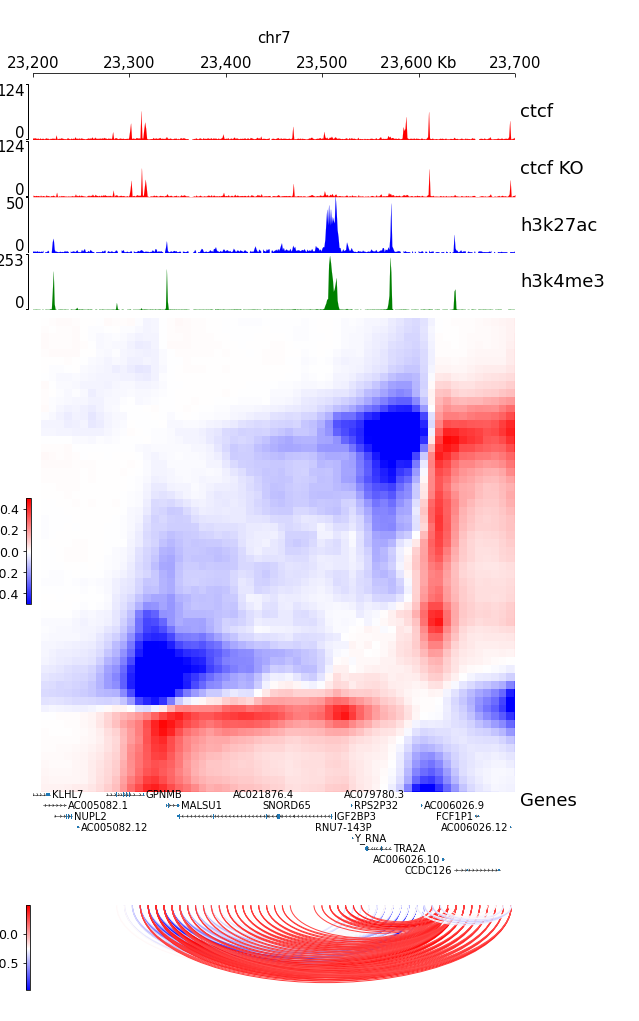

In [11]:
Image(filename='outputs/ctcf_ko_hESC_WT_50pct_chr7_23000000_ctcf_ko_tracks_diff.png', width=300)

### Sequence Perturbation

The `perturb.py` script can also be used to perturb the sequence of the input FASTA files. This is done by specifying the `--var-pos` and `--alt` arguments with lists of SNP positions and the corresponding alt base. Currently, the differences seem very small and difficult to find any statistically significant differences. We recommend using the `--plot-diff` flag with `--min-val-diff` and `--max-val-diff` set to values very close to 0.

In [12]:
! python ../src/cshark/inference/perturb.py \
    --celltype hESC_WT_50pct \
    --outname snp \
    --chr chr7 \
    --start 23000000 \
    --model ../checkpoints/deeploop_hESC_EP_CTCF_fix.ckpt \
    --seq ../cshark_data/data/hg19/dna_sequence \
    --region chr7:23200000-23700000 \
    --var-pos 23584702 \
    --alt T \
    --plot-diff \
    --min-val-diff -0.001 \
    --max-val-diff 0.001 \
    --bigwigs ctcf=../cshark_data/data/hg19/hESC_WT_50pct/genomic_features/ctcf.bw \
              h3k27ac=../cshark_data/data/hg19/hESC_WT_50pct/genomic_features/h3k27ac.bw \
              h3k4me3=../cshark_data/data/hg19/hESC_WT_50pct/genomic_features/h3k4me3.bw

Variant pos: 23584702, alt base: T
Pos: 584701, Alt: T, Ref: C
CTACTGACAT*C*TAGTGGGTA


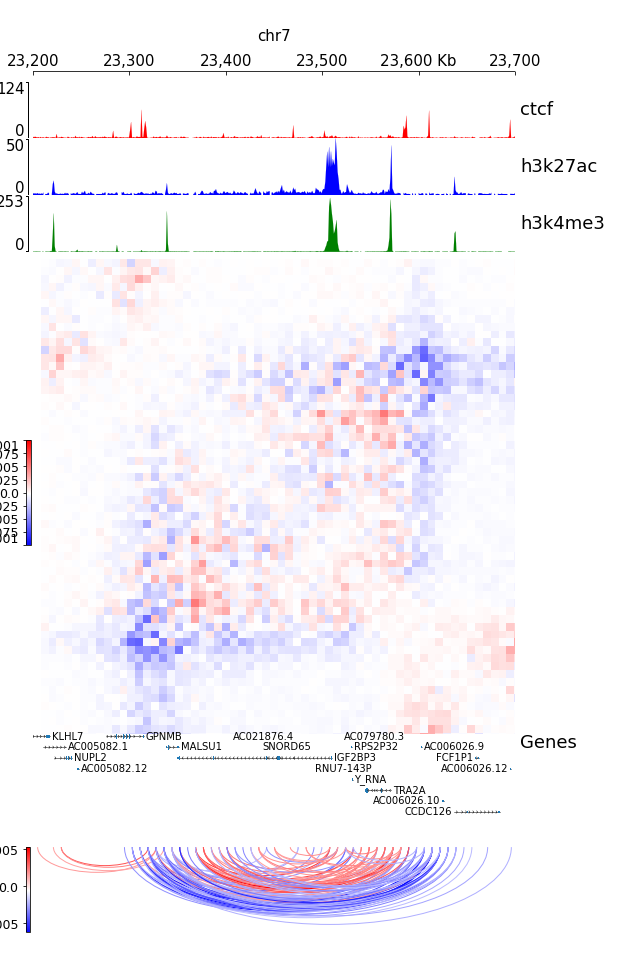

In [13]:
Image(filename='outputs/snp_hESC_WT_50pct_chr7_23000000_ctcf_ko_tracks_diff.png', width=300)

### Combined Perturbations

You can combine multiple perturbations together by simply listing them in the `--ko`, `--ko-start`, and `--ko-width` arguments. For example, here we do full 2Mb CTCF knockout followed by individual site knockout of EP tracks.

In [ ]:
! python ../src/cshark/inference/perturb.py \
    --celltype hESC_WT_50pct \
    --outname ctcf_ep_ko \
    --chr chr7 \
    --start 23000000 \
    --model ../checkpoints/deeploop_hESC_EP_CTCF_fix.ckpt \
    --seq ../cshark_data/data/hg19/dna_sequence \
    --region chr7:23200000-23700000 \
    --ko-start 23000000 23560000 23560000 \
    --ko-width 2000000 20000 20000 \
    --ko ctcf h3k27ac h3k4me3 \
    --ko-mode knockout \
    --min-val-pred 0.5 \
    --bigwigs ctcf=../cshark_data/data/hg19/hESC_WT_50pct/genomic_features/ctcf.bw \
              h3k27ac=../cshark_data/data/hg19/hESC_WT_50pct/genomic_features/h3k27ac.bw \
              h3k4me3=../cshark_data/data/hg19/hESC_WT_50pct/genomic_features/h3k4me3.bw

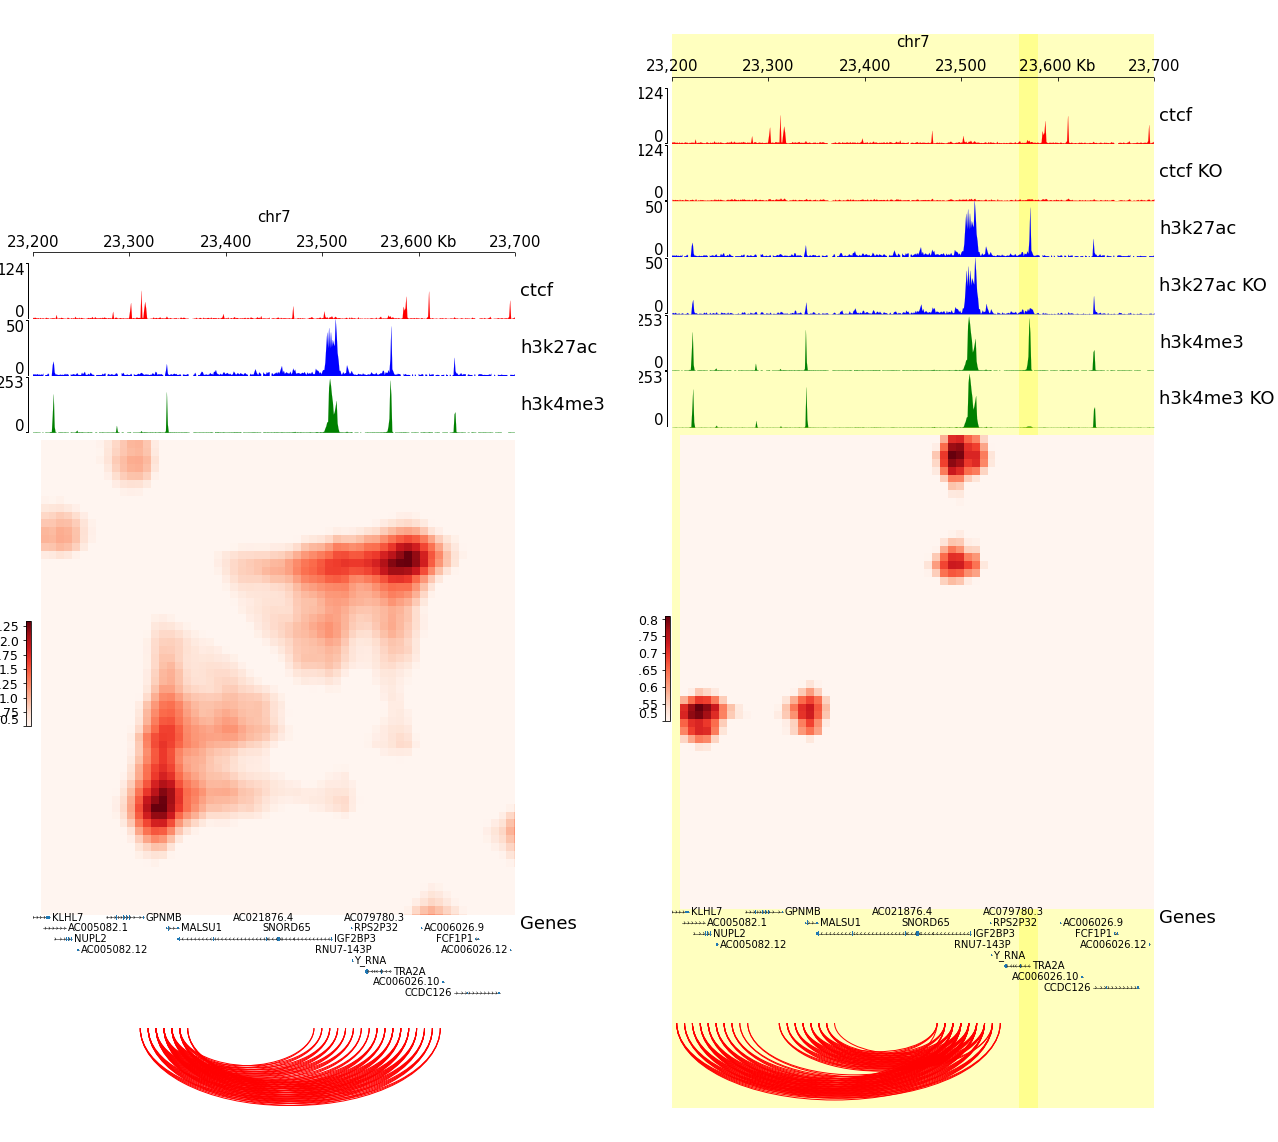

In [25]:
# 'outputs/ctcf_ep_ko_hESC_WT_50pct_chr7_23000000_ctcf_ko_tracks.png'
display_images('outputs/ctcf_ep_ko_hESC_WT_50pct_chr7_23000000_ctcf_pred_tracks.png',
                'outputs/ctcf_ep_ko_hESC_WT_50pct_chr7_23000000_ctcf_ko_tracks.png')

You can also combine the CTCF knockout and sequence perturbation by providing both sets of arguments. This will knockout the CTCF sites and perturb the sequence.

In [14]:
! python ../src/cshark/inference/perturb.py \
    --celltype hESC_WT_50pct \
    --outname ctcf_ko \
    --chr chr7 \
    --start 23000000 \
    --model ../checkpoints/deeploop_hESC_EP_CTCF_fix.ckpt \
    --seq ../cshark_data/data/hg19/dna_sequence \
    --region chr7:23200000-23700000 \
    --ko-start 23580000 \
    --ko-width 10000 \
    --ko ctcf \
    --ko-mode knockout \
    --var-pos 23584702 \
    --alt T \
    --plot-diff \
    --min-val-pred 0.5 \
    --min-val-diff -0.5 \
    --max-val-diff 0.5 \
    --bigwigs ctcf=../cshark_data/data/hg19/hESC_WT_50pct/genomic_features/ctcf.bw \
              h3k27ac=../cshark_data/data/hg19/hESC_WT_50pct/genomic_features/h3k27ac.bw \
              h3k4me3=../cshark_data/data/hg19/hESC_WT_50pct/genomic_features/h3k4me3.bw

Variant pos: 23584702, alt base: T
Pos: 584701, Alt: T, Ref: C
CTACTGACAT*C*TAGTGGGTA


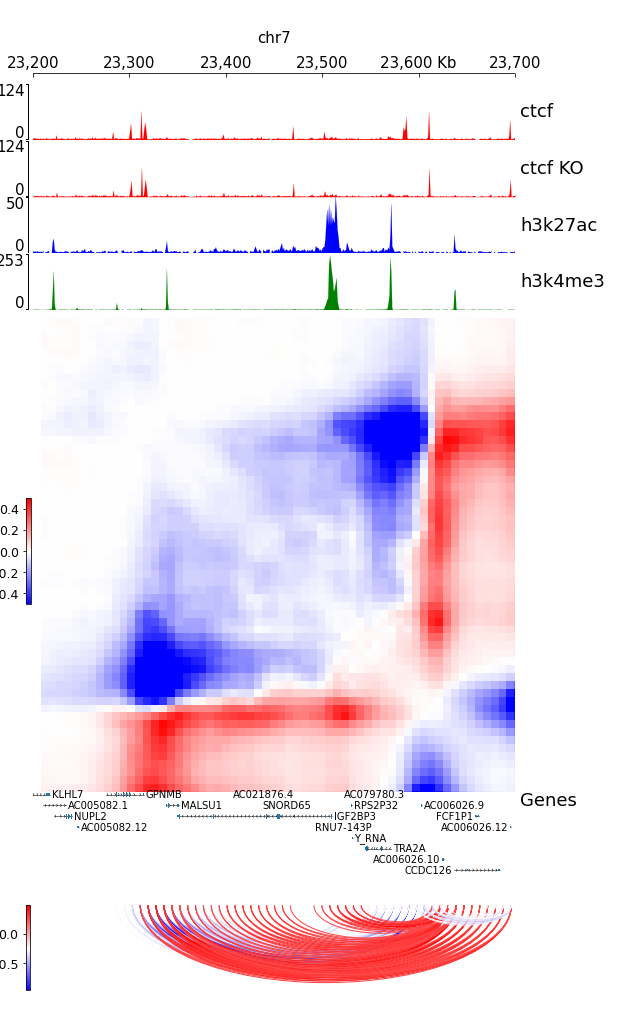

In [15]:
Image(filename='outputs/ctcf_ko_hESC_WT_50pct_chr7_23000000_ctcf_ko_tracks_diff.png', width=300)